# ConvNets Assignment

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

This classification assignment will use the CIFAR 10 library which is part of Keras.https://keras.io/api/datasets/cifar10/ and https://www.cs.toronto.edu/~kriz/cifar.html. CIFAR 10 is a collection of 50,000 training and 10,000 test images of 10 differnt classes of objects.  Using convolutional neural networks (convets, or CNN) to get the model accuracy above 80%

In [2]:
# Load the libraries
from functools import partial

import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

2025-02-06 11:32:20.500043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738809140.513588   26004 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738809140.517584   26004 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 11:32:20.532659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [4]:
# Load the CIFAR 10 library from Keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

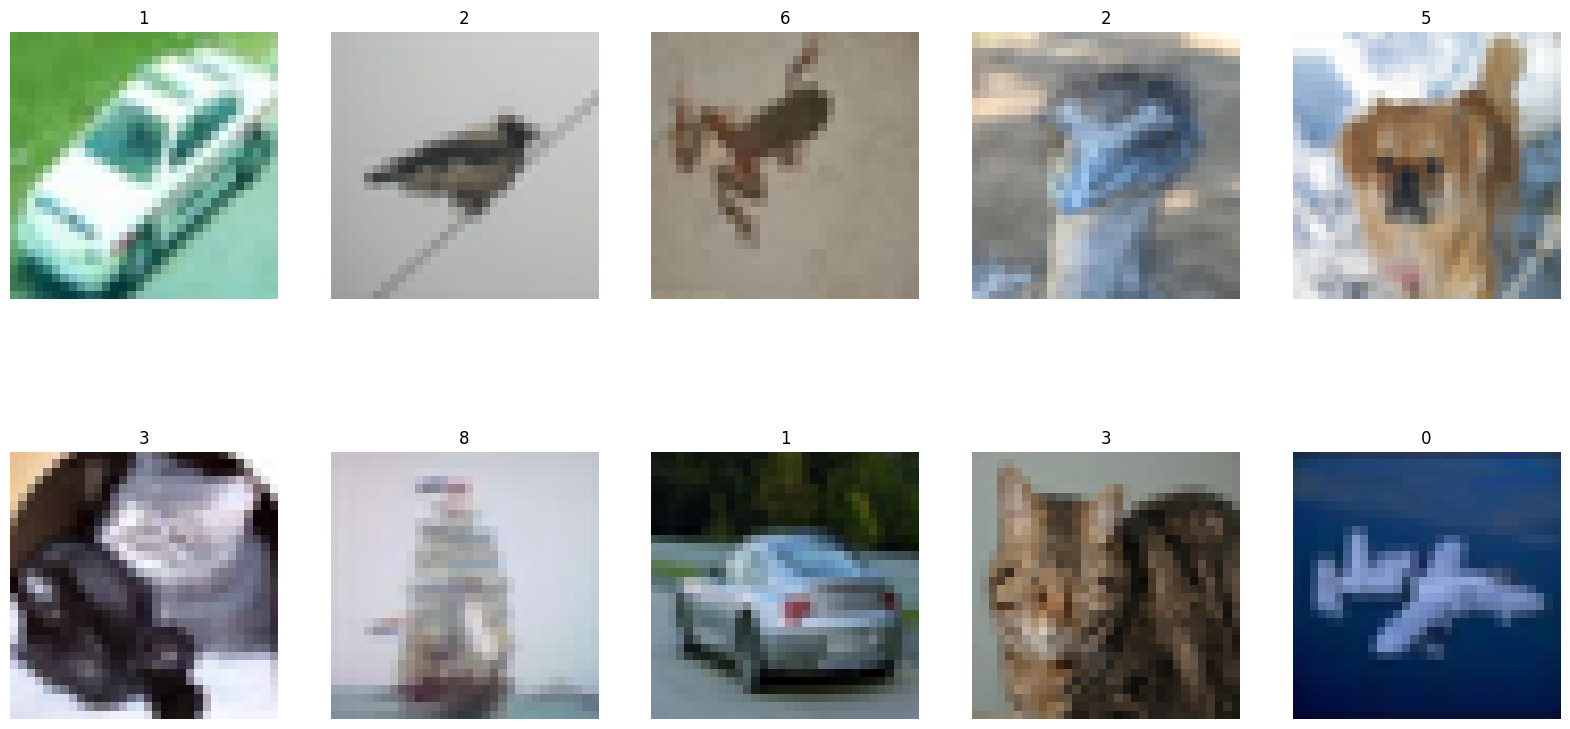

In [5]:
# View a few of the images
rand_idx = np.random.randint(0, x_train.shape[0], 10)
plt.figure(figsize=(20, 10))
for i, idx in enumerate(rand_idx):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[idx])
    plt.title(y_train[idx][0])
    plt.axis('off')

In [6]:
# Prepare the train and test images for a CNN
batch_size = 64

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1738809145.264626   26004 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:10:00.0, compute capability: 8.9
2025-02-06 11:32:25.265767: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.
2025-02-06 11:32:26.345992: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.
2025-02-06 11:32:26.914436: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2025-02-06 11:32:27.147525: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2025-02-06 11:32:27.340294: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


In [7]:
# Create a plot funtion like we did in the walk-though
def plot_history(history):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Print best validation accuracy and its epoch
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    print(f'Best validation accuracy: {best_val_acc} at epoch {best_epoch}')

### Review literature for CNN architectures and build at least 3 different architectures with varying depths, kernels, and normalization functions.  Be sure to split your data into a validation block and monitor loss and accuracy with graphs.  Build, compile, monitor, validate, and test each CNN architecture in one cell.  Try to get one of your CNN architectures to have a test accauracy above 80%.  Plot your models to verify your arcitecture is correct.
      
#### Here are is a link that reviews different CNN architectures.
#### https://medium.com/datadriveninvestor/five-powerful-cnn-architectures-b939c9ddd57b 

This function will build residual blocks to make resnet like Convolutional models.

In [8]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding='same', kernel_initializer='he_normal')

def residual_block(x, filters, kernel_size=3, stride=1):
    y = DefaultConv2D(filters, kernel_size=kernel_size, strides=stride)(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)
    y = DefaultConv2D(filters, kernel_size=kernel_size)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    if stride > 1 or x.shape[-1] != filters:
        x = DefaultConv2D(filters, kernel_size=1, strides=stride)(x)
    out = tf.keras.layers.Add()([x, y])
    return tf.keras.layers.ReLU()(out)

# Model 1

In [9]:
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = DefaultConv2D(64)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = DefaultConv2D(64)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = DefaultConv2D(128)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = DefaultConv2D(128)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = DefaultConv2D(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = DefaultConv2D(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
X = tf.keras.layers.Dense(10)(x)
outputs = tf.keras.layers.Softmax(dtype='float32')(x)
model1 = tf.keras.Model(inputs, outputs)
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             

 Total params: 1,214,784 (4.63 MB)

 Trainable params: 1,212,992 (4.63 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [10]:
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100


I0000 00:00:1738808675.044815   24702 service.cc:148] XLA service 0x766414002450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738808675.044840   24702 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-02-06 11:24:35.125282: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738808675.425242   24702 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-06 11:24:36.794696: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1818', 440 bytes spill stores, 440 bytes spill loads

2025-02-06 11:24:37.359636: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1818', 496 by

 22/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1704 - loss: 4.6886    

I0000 00:00:1738808680.268311   24702 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.3697 - loss: 2.8210 - val_accuracy: 0.4479 - val_loss: 2.3945
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5513 - loss: 2.0157 - val_accuracy: 0.5071 - val_loss: 2.1524
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6130 - loss: 1.8000 - val_accuracy: 0.5375 - val_loss: 2.0325
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6512 - loss: 1.6700 - val_accuracy: 0.4888 - val_loss: 2.3678
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6756 - loss: 1.5816 - val_accuracy: 0.6328 - val_loss: 1.7788
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6996 - loss: 1.4908 - val_accuracy: 0.6059 - val_loss: 1.8765
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7131 - loss: 1.4351 - val_accuracy: 0.6535 - val_loss: 1.7509
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7314 - loss: 1.3668 - val_accuracy: 0.637

Best validation accuracy: 0.6535000205039978 at epoch 6


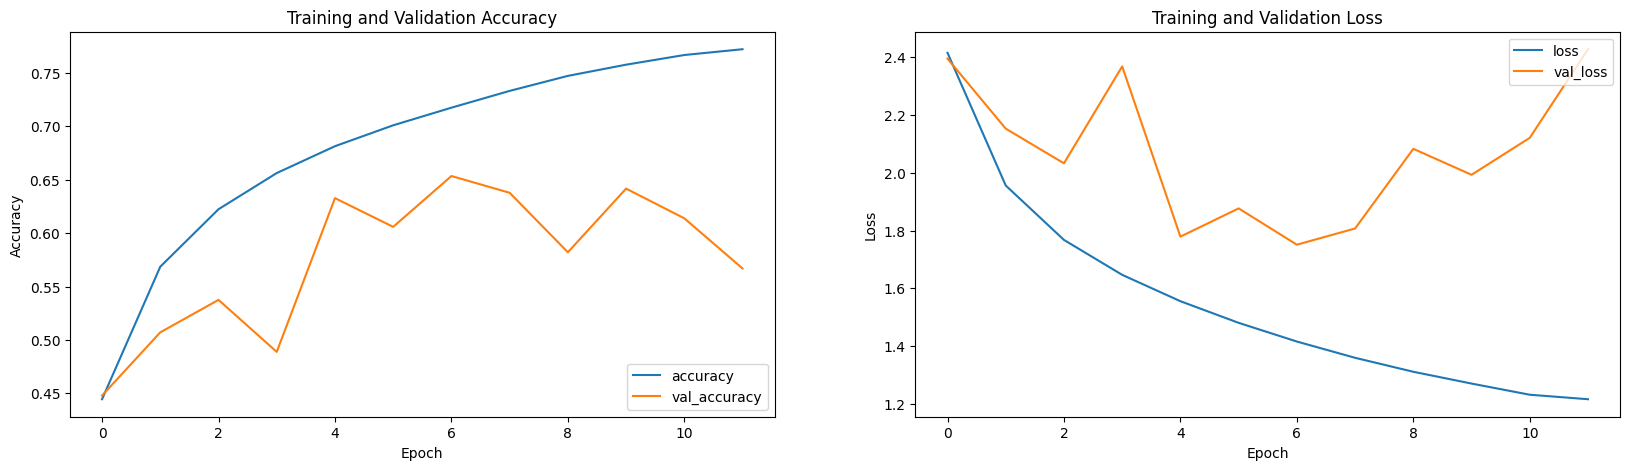

In [11]:
plot_history(history1)

That's not very good, but it looks like the model is too small.

# Model 2

In [12]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = residual_block(inputs, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(10)(x)
outputs = tf.keras.layers.Softmax(dtype='float32')(x)
model2 = tf.keras.Model(inputs, outputs)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_6[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │        256 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_8[0][0],   │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_7[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ re_lu_7[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 32, 32,    │          0 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │     73,856 │ re_lu_9[0][0]   

 Total params: 2,811,722 (10.73 MB)

 Trainable params: 2,808,138 (10.71 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [13]:
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.4327 - loss: 1.5726 - val_accuracy: 0.5901 - val_loss: 1.1921
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6857 - loss: 0.8871 - val_accuracy: 0.6808 - val_loss: 0.9799
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7718 - loss: 0.6497 - val_accuracy: 0.6663 - val_loss: 1.0300
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8227 - loss: 0.5075 - val_accuracy: 0.7781 - val_loss: 0.6412
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8646 - loss: 0.3890 - val_accuracy: 0.7527 - val_loss: 0.7985
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9002 - loss: 0.2846 - val_accuracy: 0.7757 - val_loss: 0.7586
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9247 - loss: 0.2124 - val_accuracy: 0.7806 - val_loss: 0.8005
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9392 - loss: 0.1694 -

Best validation accuracy: 0.8019999861717224 at epoch 8


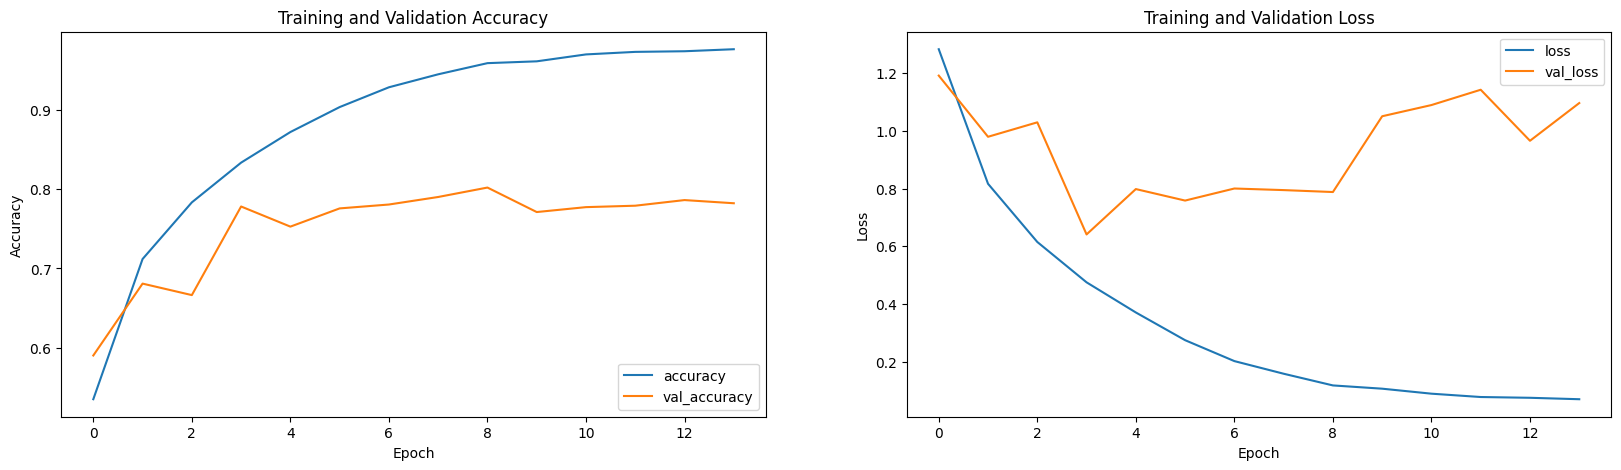

In [14]:
plot_history(history2)

That's a lot better. Hit the goal of 80%.

# Model 3

In [18]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = residual_block(inputs, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 512, stride=2)
x = residual_block(x, 512)
x = residual_block(x, 512)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10)(x)
outputs = tf.keras.layers.Softmax(dtype='float32')(x)
model3 = tf.keras.Model(inputs, outputs)
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_42 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_42[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 32, 32,    │        256 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 32, 32,    │          0 │ conv2d_51[0][0],  │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_43 (ReLU)     │ (None, 32, 32,    │          0 │ add_18[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_43[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_44 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_44[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 32, 32,    │          0 │ re_lu_43[0][0],   │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_45 (ReLU)     │ (None, 32, 32,    │          0 │ add_19[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_45[0][0]  

 Total params: 17,815,754 (67.96 MB)

 Trainable params: 17,804,234 (67.92 MB)

 Non-trainable params: 11,520 (45.00 KB)

In [19]:
history3 = model3.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.2842 - loss: 2.1825 - val_accuracy: 0.4502 - val_loss: 1.4638
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5479 - loss: 1.2674 - val_accuracy: 0.5030 - val_loss: 1.7668
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6713 - loss: 0.9462 - val_accuracy: 0.6317 - val_loss: 1.1676
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.7447 - loss: 0.7439 - val_accuracy: 0.7317 - val_loss: 0.8020
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.7964 - loss: 0.6080 - val_accuracy: 0.7515 - val_loss: 0.7589
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8351 - loss: 0.4945 - val_accuracy: 0.7570 - val_loss: 0.7772
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8680 - loss: 0.3951 - val_accuracy: 0.7777 - val_loss: 0.7667
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8954 - loss: 0

Best validation accuracy: 0.8158000111579895 at epoch 14


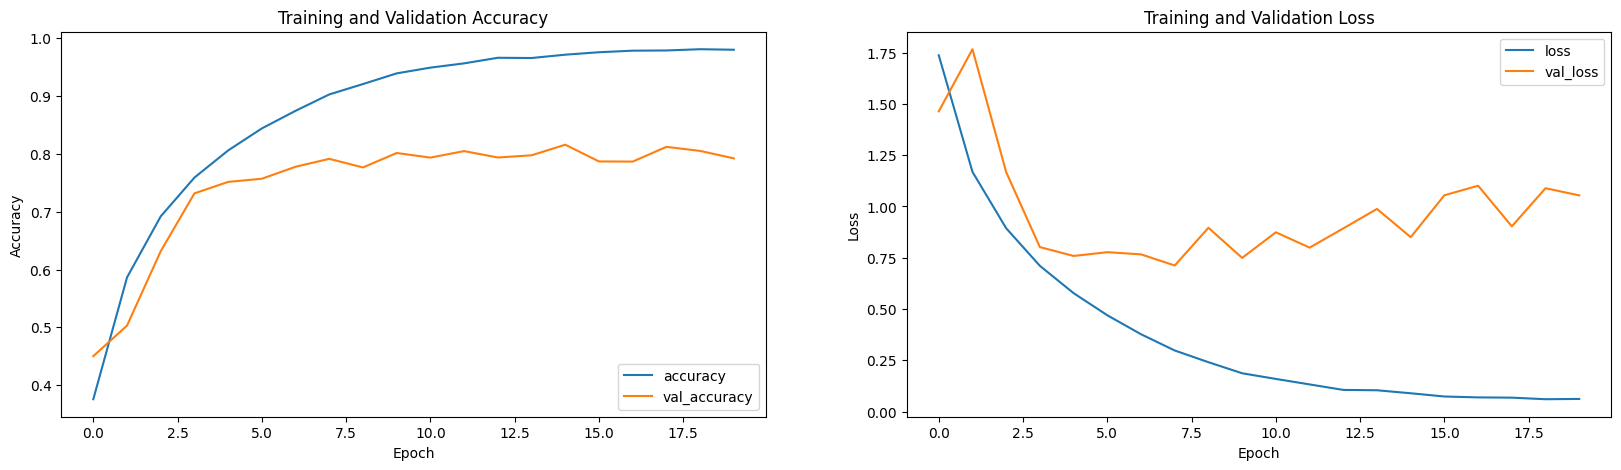

In [20]:
plot_history(history3)

Woot!

# Keras tuner

In [18]:
def resnet_builder(hp):
    n_shrinks = hp.Int('n_shrinks', 1, 2)
    n_blocks = hp.Int('n_blocks', 2, 3)
    n_filters = hp.Int('n_filters', 32, 64, step=2, sampling='log')
    dropout = hp.Float('dropout', 0.0, 0.5, step=0.25)
    augment = hp.Boolean('augment')
    
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    if augment:
        x = tf.keras.layers.RandomFlip('horizontal')(inputs)
        x = tf.keras.layers.RandomRotation(0.1)(x)
        x = tf.keras.layers.RandomZoom(0.1)(x)
        x = DefaultConv2D(n_filters, kernel_size=3)(x)
    else:
        x = DefaultConv2D(n_filters, kernel_size=3)(inputs)
    for i in range(1, n_shrinks + 2):
        for j in range(n_blocks):
            x = residual_block(x, n_filters*i, stride=2 if j == 0 and i > 1 else 1)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    dense_units = n_filters * 2**n_shrinks
    x = tf.keras.layers.Dense(dense_units, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(10)(x)
    outputs = tf.keras.layers.Softmax(dtype='float32')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
# Instantiate the Keras Tuner HyperParameters object
hp = kt.HyperParameters()
print(hp.values)

# Build the model using the resnet_builder function
model = resnet_builder(hp)

# Print the model summary
model.summary()

{}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_7 (Cast)       │ (None, 32, 32, 3) │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 32, 32,    │        896 │ cast_7[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 32, 32,    │      9,248 │ conv2d_58[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_50 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 32, 32,    │      9,248 │ re_lu_50[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 32, 32,    │          0 │ conv2d_58[0][0],  │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_51 (ReLU)     │ (None, 32, 32,    │          0 │ add_25[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 32,    │      9,248 │ re_lu_51[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_52 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │      9,248 │ re_lu_52[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 32, 32,    │          0 │ re_lu_51[0][0],   │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_53 (ReLU)     │ (None, 32, 32,    │          0 │ add_26[0][0]      │
│                     │ 32)               │            │                 

 Total params: 175,626 (686.04 KB)

 Trainable params: 174,858 (683.04 KB)

 Non-trainable params: 768 (3.00 KB)

In [46]:
tuner = kt.BayesianOptimization(resnet_builder, objective='val_accuracy', max_trials=16, hyperparameters=hp)
tuner.search(train_ds, validation_data=val_ds, epochs=12, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=3, restore_best_weights=True)])

Trial 16 Complete [00h 02m 36s]
val_accuracy: 0.7954999804496765

Best val_accuracy So Far: 0.8208000063896179
Total elapsed time: 00h 52m 33s


In [50]:
tuner.oracle.get_best_trials(1)[0].summary()

Trial 06 summary
Hyperparameters:
n_shrinks: 2
n_blocks: 3
n_filters: 64
dropout: 0.5
augment: False
Score: 0.8208000063896179


That took a really long time and I didn't even test that large of models. I just wanted to see if I could make a resnet building function and implement it with keras tuner. If I wanted to spend the time or I had more resources this could be scaled up to include larger models and test more things like kernel size and learning rates.

# Model 4

In [20]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = tf.keras.layers.RandomFlip('horizontal')(inputs)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.1)(x)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10)(x)
outputs = tf.keras.layers.Softmax(dtype='float32')(x)
model4 = tf.keras.Model(inputs, outputs)
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model4.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.3140 - loss: 2.1616 - val_accuracy: 0.4130 - val_loss: 1.9374
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.4876 - loss: 1.4153 - val_accuracy: 0.4803 - val_loss: 1.6207
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.5711 - loss: 1.2053 - val_accuracy: 0.4420 - val_loss: 2.0063
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.6314 - loss: 1.0606 - val_accuracy: 0.6102 - val_loss: 1.1471
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6704 - loss: 0.9526 - val_accuracy: 0.7116 - val_loss: 0.8270
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7064 - loss: 0.8686 - val_accuracy: 0.6839 - val_loss: 0.9627
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7276 - loss: 0.7974 - val_accuracy: 0.7123 - val_loss: 0.8949
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7508 - loss: 0

Best validation accuracy: 0.8924000263214111 at epoch 38


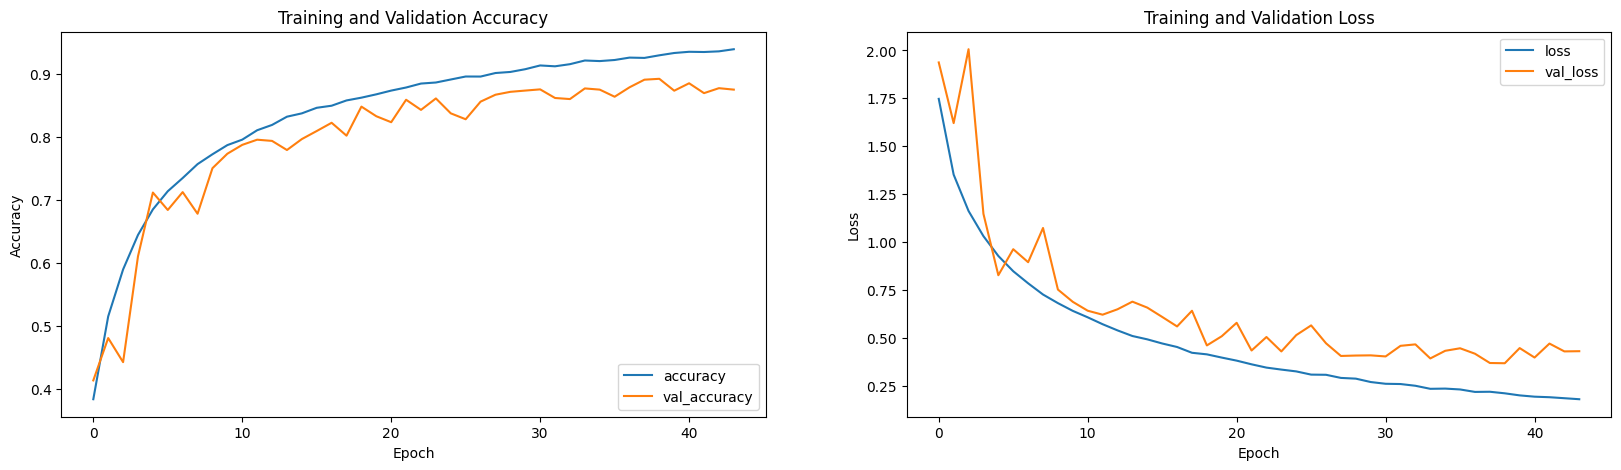

In [21]:
plot_history(history)

I built one final big model based on what performed well previously. I'd say the results are quite satisfactory. Training it took a long time. This dataset is hard, because the images are such low resolution. 

# Test set eval

In [28]:
_, accuracy = model4.evaluate(test_ds)
print(f'Test accuracy: {accuracy:.4f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8853 - loss: 0.3832
Test accuracy: 0.8835


I'm pretty happy with that. I could improve on it some more if I wanted. Maybe try a larger kernel in the first layer and train a little longer with a smaller learning rate. For the sake of this assignment, I think I've done enough.

# Model 5

In [21]:
def bn_block(x, filters, kernel_size=3, stride=1):
    y = DefaultConv2D(filters, kernel_size=kernel_size, strides=stride)(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)
    return y

In [24]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = tf.keras.layers.RandomFlip('horizontal')(inputs)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.1)(x)
x = bn_block(x, 64)
x = bn_block(x, 64)
x = bn_block(x, 64)
x = bn_block(x, 64)
x = tf.keras.layers.MaxPooling2D()(x)
x = bn_block(x, 128)
x = bn_block(x, 128)
x = bn_block(x, 128)
x = bn_block(x, 128)
x = tf.keras.layers.MaxPooling2D()(x)
x = bn_block(x, 256)
x = bn_block(x, 256)
x = bn_block(x, 256)
x = bn_block(x, 256)
x = tf.keras.layers.MaxPooling2D()(x)
x = bn_block(x, 512)
x = bn_block(x, 512)
x = bn_block(x, 512)
x = bn_block(x, 512)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10)(x)
outputs = tf.keras.layers.Softmax(dtype='float32')(x)
model5 = tf.keras.Model(inputs, outputs)
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model5.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.2934 - loss: 1.9325 - val_accuracy: 0.2943 - val_loss: 3.7559
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.4959 - loss: 1.4040 - val_accuracy: 0.4465 - val_loss: 1.9223
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5788 - loss: 1.2065 - val_accuracy: 0.5205 - val_loss: 1.6030
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6197 - loss: 1.0930 - val_accuracy: 0.4367 - val_loss: 2.3461
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6535 - loss: 1.0058 - val_accuracy: 0.6568 - val_loss: 1.0215
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6856 - loss: 0.9219 - val_accuracy: 0.6949 - val_loss: 0.8933
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7118 - loss: 0.8658 - val_accuracy: 0.6861 - val_loss: 1.0318
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7318 - loss: 0

Best validation accuracy: 0.8442000150680542 at epoch 17


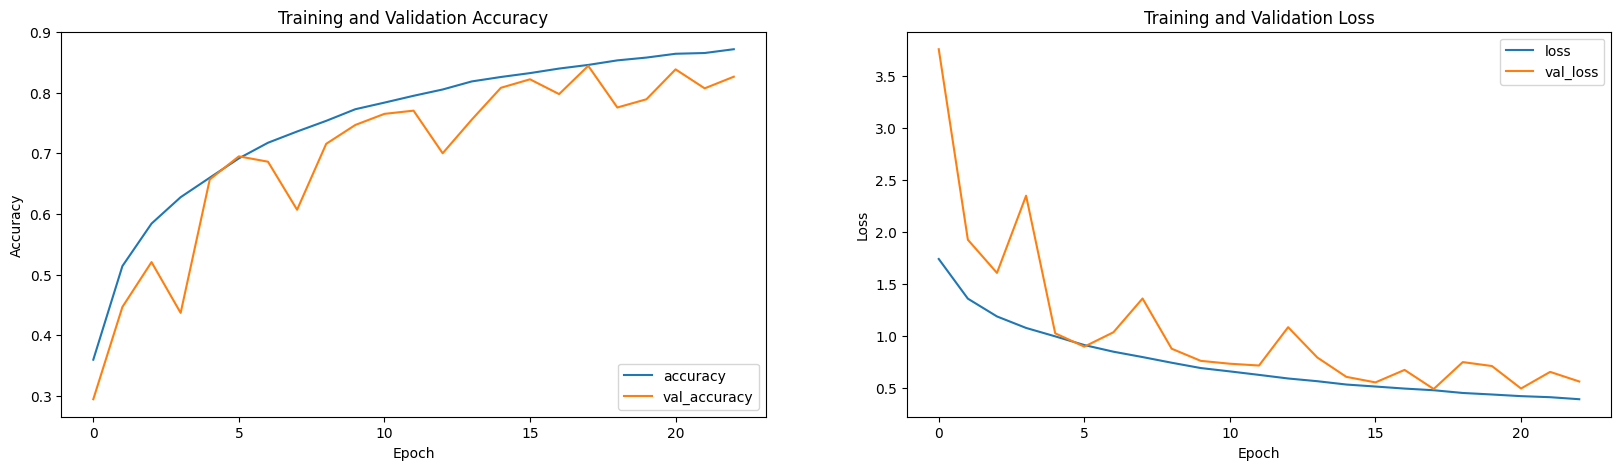

In [25]:
plot_history(history)

I wanted to see how a model would do without the residual connections. It's not as good, but it's still pretty good. 